In [ ]:
import os
import gym
from gym import spaces
from torch import nn
import torch
from collections import deque, defaultdict
import itertools
import numpy as np
import random
from scipy.stats import poisson
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import msgpack
import matplotlib.pyplot as plt
from msgpack_numpy import patch as msgpack_numpy_patch
msgpack_numpy_patch()
import pickle
import dill
SAMPLING_FREQ = [1,2,3]
TOTAL_ENERGY = 100




def load_q_table(filename):
    with open(filename, 'rb') as f:
        q_values = dill.load(f)
    return q_values
def rmse(e1,e2):
    return np.sqrt(np.mean((e1 - e2) ** 2))
class WSNEnvironment(gym.Env):

    metadata = {"render_modes": ["console"]}
    def __init__(self, num_sensors=13, sensor_coverage=0.4, sampling_freq = 2, energy = TOTAL_ENERGY, max_steps=50, threshold_prob=0.3):
        super(WSNEnvironment, self).__init__()

        # Environment parameters
        self.num_sensors = num_sensors
        self.sensor_coverage = sensor_coverage
        self.max_steps = max_steps
        self.threshold_prob = threshold_prob
        self.alpha=0.6
        self.beta=0.3


        ## this is where we should load the temprature data
        self.temprature = np.random.randint(10, 12, size=(num_sensors-1, 100))
        self.remaining_energy = [energy] * self.num_sensors

        # Initialize the environment
        self.sensor_information, self.num_points = self._generate_sensor_positions(TOTAL_ENERGY,self.temprature[:,0])

        # Define observation space
        self.observation_space = spaces.Box(low=0, high=1000, shape=(self.num_points, 3), dtype=np.float32)

        self.sampling_freq = sampling_freq

        ## Define the action_space
        self.action_space = spaces.MultiDiscrete([self.sampling_freq] * self.num_points)



        # Internal state variables
        self.step_count = 0

        # information dictionary
        self.info = {}

        # the generated event
        self.event = None

        # Number of generated events
        self.generated_events = 0
        self.similarity=0
        self.similarity_penalty=0






    def reset(self, seed=0):
        # Initialize the environment at the start of each episode
        self.step_count = 0
        self.generated_events = 0
        self.info = {'captured': 0, 'non-captured': 0}

        for i in range(self.num_points):
            self.info['sensor '+str(i)] = set()
            # initialize the energy and temprature
            self.sensor_information[i,1] = self.remaining_energy[i]
            self.sensor_information[i,0] = self.temprature[i,0]
        return self.sensor_information, self.info

    def step(self, action):
        # Execute one step in the environment
        #print(self.step_count)
        truncated = bool(self.step_count > self.max_steps)
        terminated = False

        reward = 0

        # Check termination condition
        if truncated:
            terminated = True
            return self.sensor_information, reward, terminated, truncated, self.info

        ## energy consumption
        energy_consumption = [0] * len(action)
        for i in range(len(action)):
           if action[i] == 0:
              energy_consumption[i] = action[i] * 0.3  ## energy consumption for sensing
           else:
              energy_consumption[i] = action[i] * 4 ## energy consumption for sensing and data communication

        ### update the state information


        for i in range(len(self.sensor_information)):
            for j in range(i + 1, len(self.sensor_information)):
                self.similarity = rmse(self.sensor_information[i,0], self.sensor_information[j,0])


            # Penalize pairs with high similarity and high frequency rates
                self.similarity_penalty += self.similarity * (action[i] + action[j])


        self.similarity_penalty /= (len(self.sensor_information) * (len(self.sensor_information) - 1) / 2)

    # Calculate energy efficiency
        average_energy =(np.mean(energy_consumption))
        # Utility combines penalties for redundancy and rewards for high average energy
        reward = -self.alpha * (self.similarity_penalty) - self.beta * average_energy
        reward




        for i in range(len(self.sensor_information)):
            self.sensor_information[i,0] = self.temprature[i,self.step_count+1]
            self.sensor_information[i,1] = self.sensor_information[i,1] - energy_consumption[i]


        ## something should be considered 1) lower remaining energy, higher penalty for sensing and collecting data
        ## 2) how to measure the redundancy, for example, if the temprature of some devices have the similar values, but those devices all take the action for sending the data, then it should receive the penalty?
        ## 3) higher sampling frequency, higher energy consumption
        ## 4) additional terminate conditions: if all sensors die out



        self.step_count += 1

        # Return the next observation, reward, termination signal, and additional information
        return self.sensor_information, reward, terminated, truncated, self.info, self.sensor_information[:,1]

    def _generate_sensor_positions(self,energy,temp):

        # Set a fixed random seed for reproducibility
        np.random.seed(42)

        # Define the intensity (lambda) for the Poisson process
        intensity = self.num_sensors / (1 * 1)  # Adjust as needed based on the size of the space

        # Generate the number of points based on a Poisson distribution
        num_points = poisson(intensity).rvs()

        # Generate the sensor positions uniformly at random within the space
        sensor_information = np.zeros((num_points, 2))

        sensor_information[:, 0] = temp

        # Fill the second column with 100
        sensor_information[:, 1] = energy

        # Create a new column of zeros with the same number of sensors to calculate the number of pulling for each one
        #zeros_column = np.zeros((num_points, 1))

        # Concatenate the original array with the new column of zeros
        # sensor_positions_with_zeros = np.hstack((sensor_positions, zeros_column))


        return sensor_information.astype(np.float32), num_points

    def render(self):
        pass

    def close(self):
        pass


class WSNEnvironmentAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """

        ### initialize the q-table
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.nvec))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: np.ndarray) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # Convert numpy array to tuple
        obs_key = tuple(tuple(row) for row in obs)
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit) instead of one action, we generate an action vector
        else:
            return np.unravel_index(np.argmax(self.q_values[obs_key]), self.q_values[obs_key].shape)

    def update(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        terminated: bool,
        next_obs: np.ndarray,
    ):
        """Updates the Q-value of an action."""
        next_obs_key = tuple(tuple(row) for row in next_obs)
        m_obs = tuple(tuple(row) for row in obs)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs_key])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[m_obs][action]
        )

        self.q_values[m_obs][action] = (
            self.q_values[m_obs][action] + self.lr * temporal_difference
        )


        self.training_error.append(temporal_difference)
    def save_q_table(self, filename):
      with open(filename, 'wb') as f:
          dill.dump(self.q_values, f)


    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)



# q_table = load_q_table('q_table.pkl')

In [ ]:
env = WSNEnvironment()

# hyperparameters
learning_rate = 0.01
n_episodes = 10_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = WSNEnvironmentAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

episodes = 20
scores = []

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    m_obs = tuple(tuple(row) for row in obs)
    done = False

    # play one episode
    while not done:
        action = agent.get_action(m_obs)
        next_obs, reward, terminated, truncated, info, energy_comsumption = env.step(action)

        m_next_obs = tuple(tuple(row) for row in next_obs)
        # update the agent
        agent.update(m_obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        m_obs = m_next_obs

    agent.decay_epsilon()


for episode in range(1, episodes+1):
    state, info = env.reset()
    done = False
    score = 0

    while not done:
        action = agent.get_action(state)
        n_state, reward, terminated, truncated, info, energy_remain_list = env.step(action)
        score += reward
        done = terminated or truncated
        state = n_state


    scores.append(score)
    if (episode==n_episodes-1):
      filename = 'q_table.pkl'
      agent.save_q_table(filename)





    print('Episode:{}\t Score:{:.2f} \t{}'.format(episode, score, info))



scoresW=scores
# Print average score
print('Average Score:', np.mean(scores))
Q_Learning_Scheduler = scoresW



# Save Q-table after training
# save_q_table(agent.q_values, 'q_table.pkl')

# Load Q-table before testing
# q_table = load_q_table('q_table.pkl')

In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00


## Random Scheduling


In [ ]:
episodes = 100
random_scores = []
energies = []


for episode in range(1, episodes+1):
    state, info = env.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info, energy_remain_list = env.step(action)
        score += reward
        done = terminated or truncated
    average_energy_remain = np.mean(energy_remain_list)
    random_scores.append(score)
    energies.append(average_energy_remain)
    print('Episode:{}\t Score:{:.2f} \t{}'.format(episode, score, info))
    print('Average Energy Remain:', average_energy_remain)

# Print average score
print('Average Score:', np.mean(random_scores))
Random_scheduler = random_scores
print("score are", Random_scheduler)

ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:
!pip install msgpack-numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


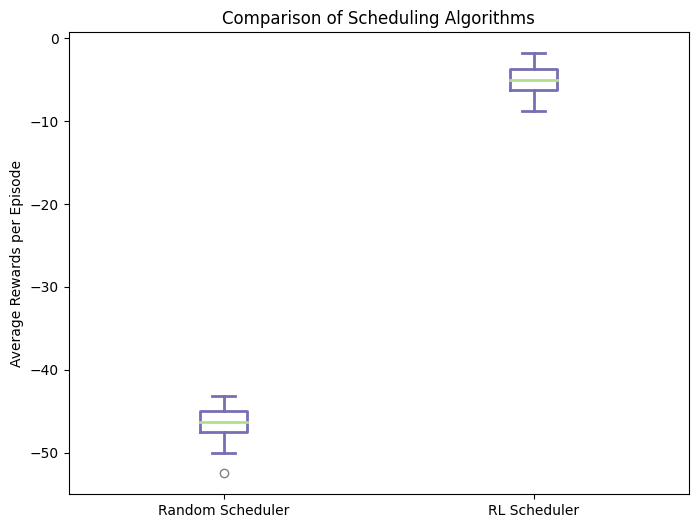

In [ ]:
# Create a 2D array where each row corresponds to a scheduling algorithm's reward per episode
data_to_plot = [Random_scheduler, Q_Learning_Scheduler]

fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
bp = ax.boxplot(data_to_plot)

# Customize boxplot (you can skip this if you don't need customization)
for box in bp['boxes']:
    box.set(color='#7570b3', linewidth=2)

for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

# Add labels and title
ax.set_xticklabels(['Random Scheduler',  'RL Scheduler'])
ax.set_ylabel('Average Rewards per Episode')
plt.title('Comparison of Scheduling Algorithms')

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


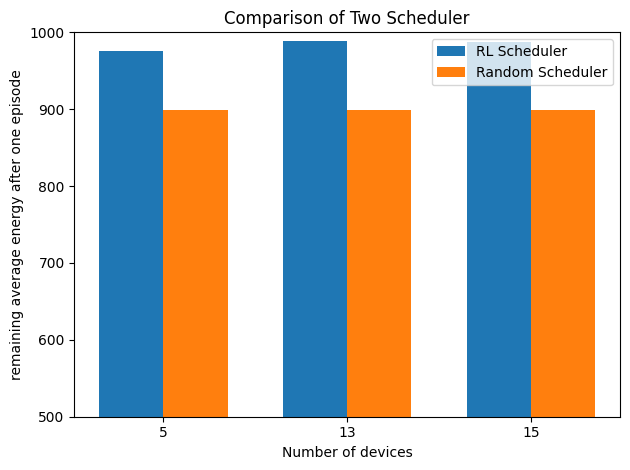

In [ ]:
#
categories = ['5', '13', '15']
values_group1 = [976.12, 988.7833, 987.8001]
values_group2 = [899.0, 899.0, 899.0]


bar_width = 0.35
index = np.arange(len(categories))

# plot
plt.bar(index, values_group1, bar_width, label='RL Scheduler')
plt.bar(index + bar_width, values_group2, bar_width, label='Random Scheduler')

plt.ylim(500, 1000)
#
plt.xlabel('Number of devices')
plt.ylabel('remaining average energy after one episode')
plt.title('Comparison of Two Scheduler')
plt.xticks(index + bar_width / 2, categories)
plt.legend()

# 显示图例
plt.tight_layout()
plt.show()